In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [3]:
num_classes = 10
input_shape = (28, 28, 1) # width x height x channels

In [4]:
# Carichiamo il data set

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
print(f'Dimensioni degli input: {x_train.shape}, dimensioni delle etichette: {y_train.shape}')

Dimensioni degli input: (60000, 28, 28), dimensioni delle etichette: (60000,)


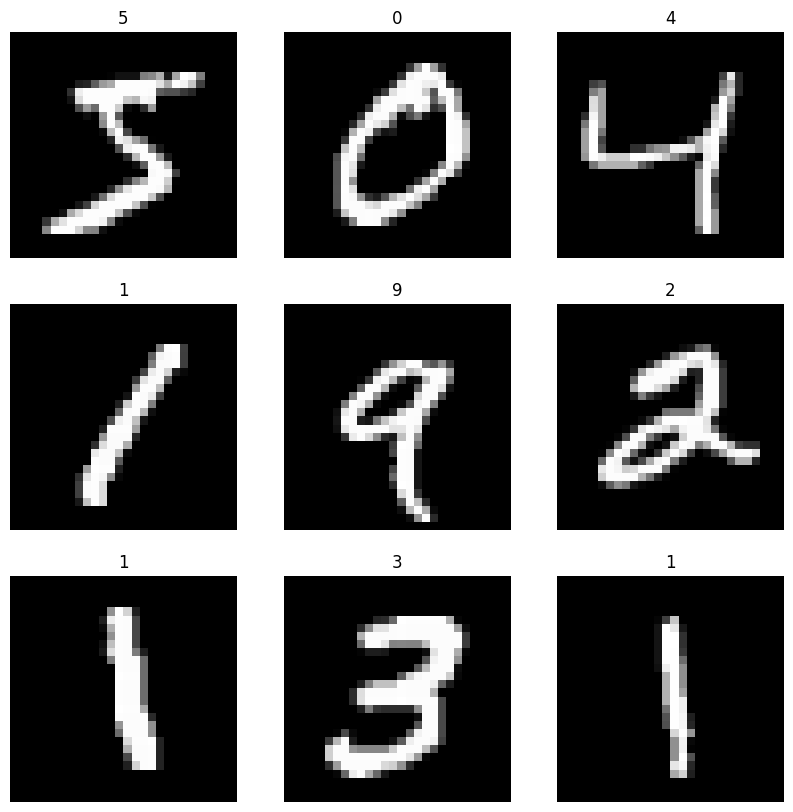

In [11]:
def plot_data(x_train, y_train):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(x_train[i], cmap='gray')
        plt.title(y_train[i])
        plt.axis('off')

    plt.show()

plot_data(x_train, y_train)

In [7]:
x_train = x_train.astype('float32')/255         # normalizzo in [0, 1] dividendo per il massimo livello di grigio
x_test = x_test.astype('float32')/255

# Espandiamo le dimensioni dei tensori per accogliere le feature map estratte dai layer convoluzionali
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f'Dimensioni degli input: {x_train[0].shape}')

Dimensioni degli input: (28, 28, 1)


In [8]:
x_train.shape

(60000, 28, 28, 1)

In [12]:
# Costruiamo la pipeline di data augmentation
data_augmentation_layers = [
    layers.RandomRotation(0.1,fill_value=0.0),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.1, fill_value=0.0)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)

    return images

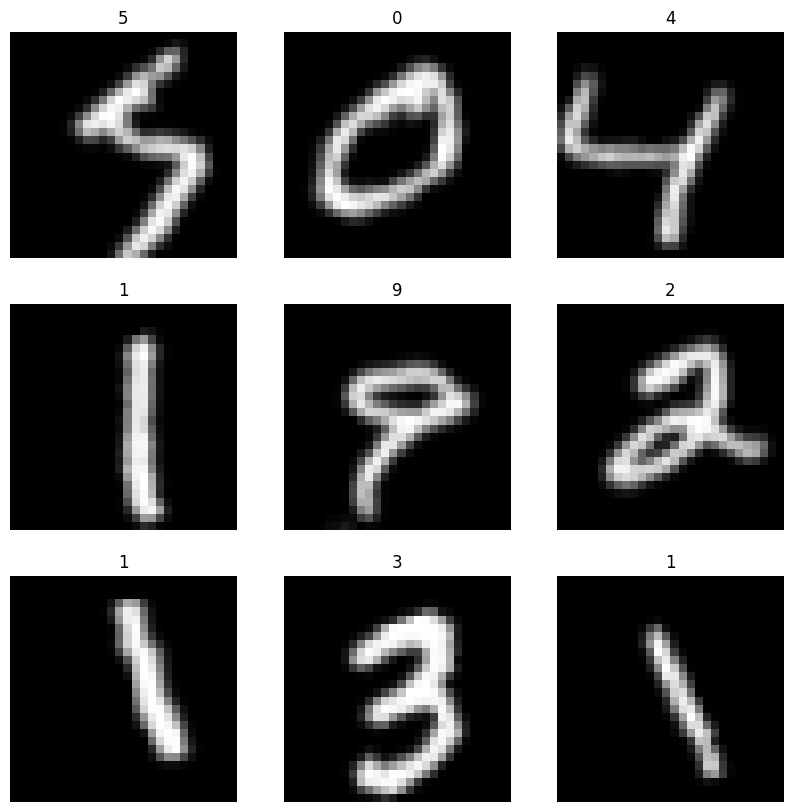

In [13]:
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented = data_augmentation(x_train[i])
    plt.imshow(augmented, cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()


In [15]:
# Modello con API sequenziale

model = keras.Sequential(
    [
        # Input
        keras.Input(shape=input_shape),

        # Data augmentation
        layers.RandomRotation(0.1,fill_value=0.0),
        layers.RandomTranslation(height_factor=0.05, width_factor=0.1, fill_value=0.0),

        # Primo layer convoluzionale
        layers.Conv2D(32,                   # feature maps
                      kernel_size=(3,3),    # dimensione kernel
                      activation='relu',    # funzione di attivazione ReLU
                      strides=(1,1),        # default stride 1
                      padding='valid'       # la dimensione di uscita è dim - kernel_size + 1
                      ),

        # Secondo layer convoluzionale
        layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Terzo layer convoluzionale
        layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Quarto layer convoluzionale
        layers.Conv2D(32, kernel_size=(3,3),activation='relu'),
        layers.GlobalAveragePooling2D(),

        # Flatten delle feature per entrare nel classificatore
        layers.Flatten(),

        # Classificatore denso con dropout
        layers.Dropout(0.25),
        layers.Dense(num_classes, activation='softmax')

    ]
)

model._name="Conv 2D per MNIST digits"

model.summary()

Model: "Conv 2D per MNIST digits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 random_translation_2 (Rand  (None, 28, 28, 1)         0         
 omTranslation)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                          

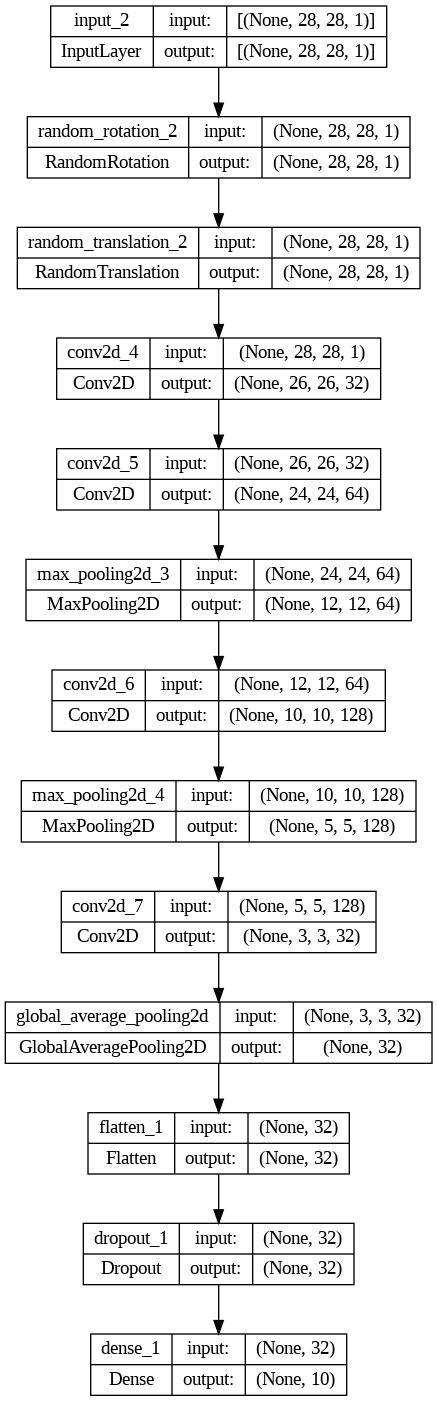

In [17]:
keras.utils.plot_model(model,show_shapes=True)

In [20]:
# Creiamo il modello in forma funzionale

def make_model(input_shape, num_classes):

    # Input
    inputs = keras.Input(shape=input_shape)

    # Data augmentation
    x = data_augmentation(inputs)

    # Primo layer convoluzionale
    x = layers.Conv2D(32,                   # feature maps
                  kernel_size=(3,3),    # dimensione kernel
                  strides=(1,1),        # default stride 1
                  padding='valid'       # la dimensione di uscita è dim - kernel_size + 1
                  )(x)
    x = layers.Activation('relu')(x)

    # Secondo layer convoluzionale
    x = layers.Conv2D(64, kernel_size=(3,3),activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Terzo layer convoluzionale
    x = layers.Conv2D(128, kernel_size=(3,3),activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Quarto layer convoluzionale
    x = layers.Conv2D(32, kernel_size=(3,3),activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Flatten delle feature per entrare nel classificatore
    x = layers.Flatten()(x)

    # Classificatore denso con dropout
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Conv2D_MNIST_digits")

model = make_model(input_shape, num_classes)

model.summary()

Model: "Conv2D_MNIST_digits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 random_rotation (RandomRot  (None, 28, 28, 1)         0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 28, 28, 1)         0         
 Translation)                                                    
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 activation_1 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)

In [26]:
# Impostiamo i parametri di addestramento del modello

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
    keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                    filepath='/content/MyDrive/MyDrive/training/weights.{epoch:02d}--{val_loss:.2f}.keras',
                                    save_freq='epoch')
]

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9, weight_decay=0.1),
    metrics=["accuracy"]
)

history = model.fit(
    x_train,
    y_train,
    verbose=2,
    shuffle=True,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/50
1500/1500 - 10s - loss: 0.2636 - accuracy: 0.9298 - val_loss: 0.2173 - val_accuracy: 0.9617 - 10s/epoch - 7ms/step
Epoch 2/50
1500/1500 - 6s - loss: 0.2656 - accuracy: 0.9265 - val_loss: 0.1382 - val_accuracy: 0.9653 - 6s/epoch - 4ms/step
Epoch 3/50
1500/1500 - 7s - loss: 0.2698 - accuracy: 0.9283 - val_loss: 0.1317 - val_accuracy: 0.9672 - 7s/epoch - 5ms/step
Epoch 4/50
1500/1500 - 6s - loss: 0.2737 - accuracy: 0.9278 - val_loss: 0.1715 - val_accuracy: 0.9685 - 6s/epoch - 4ms/step
Epoch 5/50
1500/1500 - 8s - loss: 0.2835 - accuracy: 0.9241 - val_loss: 0.1136 - val_accuracy: 0.9787 - 8s/epoch - 5ms/step
Epoch 6/50
1500/1500 - 6s - loss: 0.2811 - accuracy: 0.9255 - val_loss: 0.1626 - val_accuracy: 0.9738 - 6s/epoch - 4ms/step
Epoch 7/50
1500/1500 - 7s - loss: 0.2775 - accuracy: 0.9258 - val_loss: 0.1700 - val_accuracy: 0.9622 - 7s/epoch - 5ms/step
Epoch 8/50
1500/1500 - 6s - loss: 0.2901 - accuracy: 0.9229 - val_loss: 0.1909 - val_accuracy: 0.9458 - 6s/epoch - 4ms/step
Epoch 

In [27]:
# valutiamo sul test set

test_scores = model.evaluate(x_test, y_test, verbose=2)

print(f'Test loss: {test_scores[0]:5.2f}\nTest accuracy: {test_scores[1]:5.2f}')

313/313 - 1s - loss: 0.1332 - accuracy: 0.9698 - 1s/epoch - 4ms/step
Test loss:  0.13
Test accuracy:  0.97
